# TDA Tutorial: 3-D Manifolds
By: David Cole and Victor M. Zavala

Based on work done by Dr. Alexander Smith and published [here](https://doi.org/10.1016/j.compchemeng.2021.107463). Code for creating the visualizations was constructured with the help of ChatGPT

To access this notebook in Google Colab, please click below:

<a href="https://githubtocolab.com/zavalab/Tutorials/blob/master/CBE660/TDA_3D_Manifolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## 3D Manifolds with Cubical Complexes

Manifolds are not restricted to 2 dimensions (e.g., images), and below we will explore a 3-D manifold (a 3-D density field). This kind of data can arise in many applications, such as a temperature or pressure profile in a chemical reactor. As with images, we can use cubical complexes to "model" the data. In the tutorial on 2-D manifolds, the cubical complexes were formed by rectangles that captured the surface of the manifold and which encoded data. Cubical complexes can likewise be applied to higher dimensional data as well; for a 3-D manifold, the cubical complex forms rectangular prisms (i.e., they are expanded across a third dimension). Below we will consider an example of the concentration of a chemical in a 3-D space.

## Characterizing behavior of a Reaction-Diffusion System

In this example, we use the EC (applied to cubical complexes) to characterize the reaction-diffusion behavior across a spatial and temporal space. This problem has three dimensions ($x_1$ and $x_2$ in the spatial dimension and $t$ for time) and the reaction diffusion behavior is described by the following PDE:

$$ \frac{\partial u(x, t)}{\partial t} = D\left( \frac{\partial^2 u(x, t)}{\partial x_1^2} + \frac{\partial^2 u(x, t)}{\partial x_2^2} \right)  + R \left(v(x, t) - u(x, t) \right)$$

$$ \frac{\partial v(x, t)}{\partial t} = D\left( \frac{\partial^2 v(x, t)}{\partial x_1^2} + \frac{\partial^2 v(x, t)}{\partial x_2^2} \right)  + R \left(u(x, t) - v(x, t) \right)$$

Where $x$ describes the spatial domain, $D$ is a diffusion coefficient, $R$ is a reaction coefficient, and $u$ and $v$ are the concentrations of reactants over space and time.

We will first generate the data we need for this problem by simulating the models above using the `RD_Model` function which we define below.

In [2]:
# If you do not have Gudhi installed, uncomment and run the line below
#!pip install gudhi

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from sklearn.decomposition import PCA
from scipy.stats import zscore
# If you are not running in GoogleCollab, you can uncomment the line below for interactive notebooks
#%matplotlib notebook

# Define the problem sizes
size = 30  # size of the 2D grid
dx = 2./ size  # space step

T = 9.0  # total time
dt = .3  # time step
n = int(T / dt)  # number of iterations

# Set the seed for reproducability
np.random.seed(10)

# Define a laplacian function for the diffusion portion of the above equations
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

# Define the Reaction-Diffusion simulation
# This will go over n = 30 iterations, where each iteration is a step in time
# This function returns a 3D array of the U values
def RD_Model(D,R):
    # Initialize U and V values
    U = np.random.rand(size, size)
    V = np.random.rand(size, size)

    Us = []

    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        # We take the values of u and v inside the grid.
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # We update the variables.
        U[1:-1, 1:-1], V[1:-1, 1:-1] = \
            Uc + dt * (D*deltaU + R*(Vc - Uc)),\
            Vc + dt * (D*deltaV + R*(Uc - Vc))
        # Neumann conditions
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]

        Uz = np.array(U)

        Us.append(Uz)

    return np.stack(Us)

Now that we have defined the required functions, we will run 3 different sets of 30 simulations. We will run these simulations with different $R$ and $D$ values and then use the EC to characterize the spatial-temporal behavior of these sytems.

In [39]:
#Select Diffusion (D) and Reaction (R) Parameters
D = 3e-4
R = 2.5

#Num Sims
s = 30

# Define a list for simulations with D and R as the coefficients and run the sims
U1 = []
for i in range(s):
    U1.append(RD_Model(D,R))

# Define a list for simulations with D and 0.5 * R as the coefficients and run the sims
U2 = []
for i in range(s):
    U2.append(RD_Model(D,.5*R))

# Define a list for simulations with 2 * D and R as the coefficients and run the sims
U3 = []
for i in range(s):
    U3.append(RD_Model(2*D,R))

We will now visualize one example simulation from each of these simulations. We will do this by visualizing a 3-D plot with a point for each position in space and time and color this point by the concentration of U.

<IPython.core.display.Javascript object>


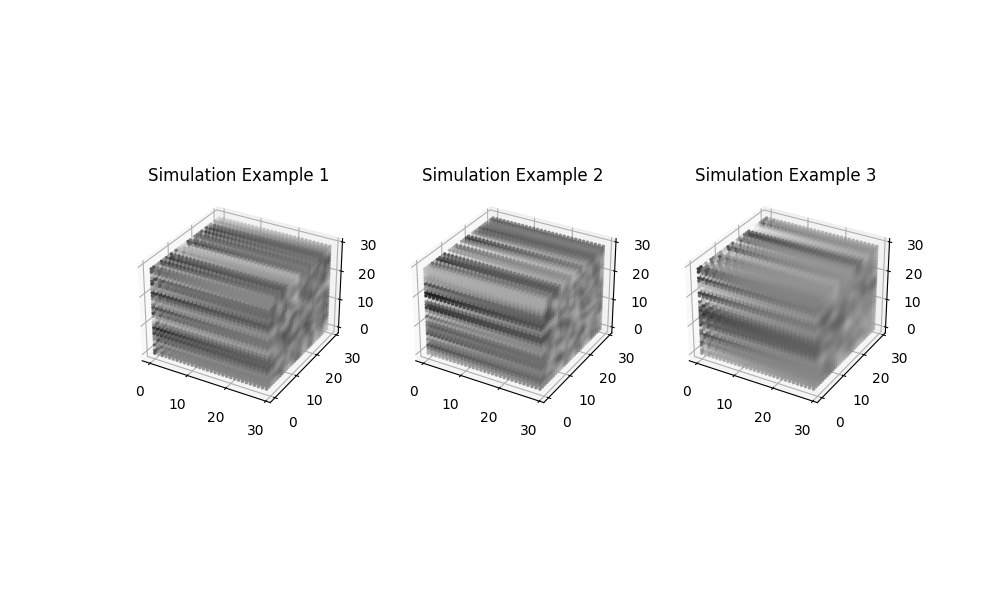

Text(0.5, 0.92, 'Simulation Example 3')

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the coordinates for each element in the 3D array
x, y, z = np.indices(U1[0].shape)
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = U1[1].flatten()  # Flatten the array values to match coordinates

fig = plt.figure(figsize=(10, 6))

# Plot the first point cloud
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(x, y, z, c=values,s = 3, cmap='gray')  # You can choose a different cmap here
ax1.set_title("Simulation Example 1")

values = U2[0].flatten()  # Flatten the array values to match coordinates
ax2 = fig.add_subplot(132, projection='3d')
scatter = ax2.scatter(x, y, z, c=values,s = 3, cmap='gray')  # You can choose a different cmap here
ax2.set_title("Simulation Example 2")

values = U3[0].flatten()  # Flatten the array values to match coordinates
ax3 = fig.add_subplot(133, projection='3d')
scatter = ax3.scatter(x, y, z, c=values,s = 3, cmap='gray')  # You can choose a different cmap here
ax3.set_title("Simulation Example 3")

Note that all three simulations do not visualling look very different. However, the EC can capture some of the spatial and temporal differences obsvered.

In Tutorial 2, we showed how a cubical complex can be created for a 2-D image. In this case, we have a 3-D space, and our cubical complexes can still capture these structures, but each complex will be a higher dimension (e.g., each "building block" will be a rectangular prism instead of just a rectangle. This change is easy to make within Gudhi, where we pass three values to the `dimensions` argument rather than only 2. Since we are in a 3-D space, we also will have three betti numbers to compute the EC.

In [41]:
# Define filtration range and increments
numPoints = 1000;
filtrationStart = 0;
filtrationEnd = 1;
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

# Function returns an euler characteristic curve for a given space
def getEC(data):
    cubeplex = gd.CubicalComplex(dimensions  = [np.shape(data)[0],np.shape(data)[1],np.shape(data)[2]],top_dimensional_cells=np.ndarray.flatten(data));
    cubeplex.persistence();
    ec = np.zeros(numPoints);
    for (i,fval) in enumerate(np.flip(filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        ec[i] = betti[0] - betti[1] + betti[2];
    return ec;

# Do a Fourier transform for each simulation
# This will be used later for a comparison with the EC
fft1 = []
fft2 = []
fft3 = []
for k in range(s):
    fft1.append(np.real(np.fft.fftn(U1[k])).flatten())
for k in range(s):
    fft2.append(np.real(np.fft.fftn(U2[k])).flatten())
for k in range(s):
    fft3.append(np.real(np.fft.fftn(U3[k])).flatten())

# Define lists for the EC and compute the EC
ec3 = []
ec2 = []
ec1 = []

for k in range(s):
    ec1.append(getEC(U1[k]))
for k in range(s):
    ec2.append(getEC(U2[k]))
for k in range(s):
    ec3.append(getEC(U3[k]))

# Convert the EC lists to an array
ec3v = np.stack(ec3)
ec2v = np.stack(ec2)
ec1v = np.stack(ec1)

We will next plot the EC for each simulation and color the curve based on the R/D values

<IPython.core.display.Javascript object>


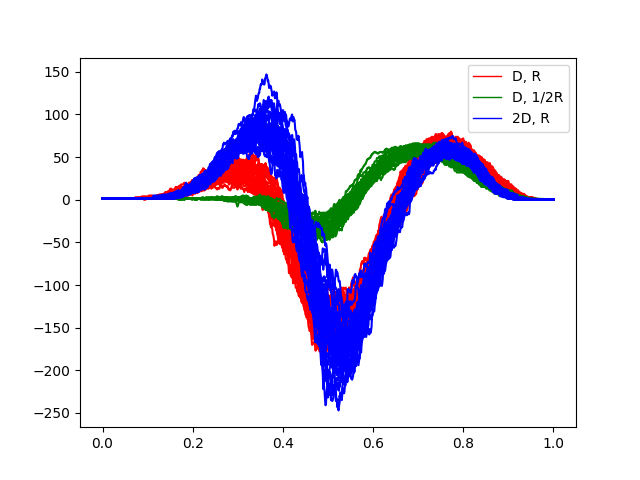

In [42]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Create an array of the ECs
A = np.vstack([ec1,ec2,ec3])

# Define a figure for plotting
plt.figure()

# Define legend elements
legend_elements = [
                    Line2D([0],[0], color = "r", lw = 1, label = "D, R"),
                    Line2D([0],[0], color = "g", lw = 1, label = "D, 1/2R"),
                    Line2D([0],[0], color = "b", lw = 1, label = "2D, R"),
]
for i in range(90):
    if i < 30:
        plt.plot(filtrations, A[i,:],color = 'r')
    elif i <  60:
        plt.plot(filtrations, A[i,:],color = 'g')
    else:
        plt.plot(filtrations, A[i,:],color = 'b')

plt.legend(handles = legend_elements)
plt.show()

In the above figure, we can see that the EC curves for the different simulation sets all have distinct shapes. To highlight these differences, we also plot the average of each simulation set below

<IPython.core.display.Javascript object>


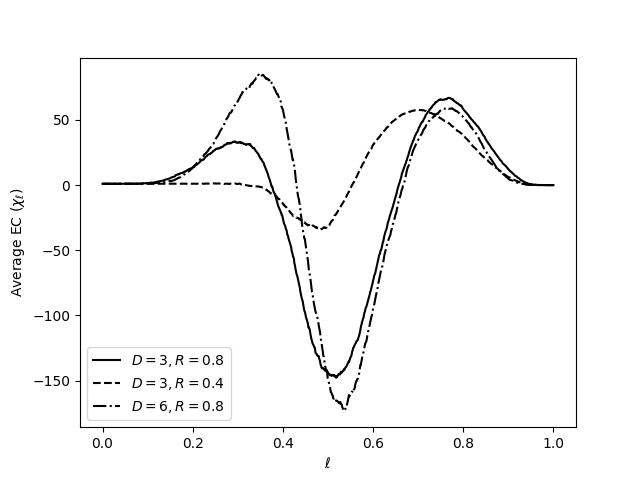

In [43]:
# Compute the average of the three different simulation sets
A1 = np.mean(A[0:30,:],axis = 0)
A2 = np.mean(A[30:60,:],axis = 0)
A3 = np.mean(A[60:90,:],axis = 0)

# Plot the average EC
plt.figure()
plt.plot(filtrations, A1, 'k', label = "$D=3,R=0.8$")
plt.plot(filtrations, A2, '--k', label = "$D=3,R=0.4$")
plt.plot(filtrations, A3, '-.k',label = "$D=6,R=0.8$")

plt.legend()
plt.ylabel("Average EC ($\chi_{\ell}$)")
plt.xlabel("$\ell$")

plt.show()

As with the image analysis that we did previously, we can do PCA to see if we can identify separation of the EC curves. We compute the EC below, and we again see that there is distinct separation from the simulation sets.

<IPython.core.display.Javascript object>


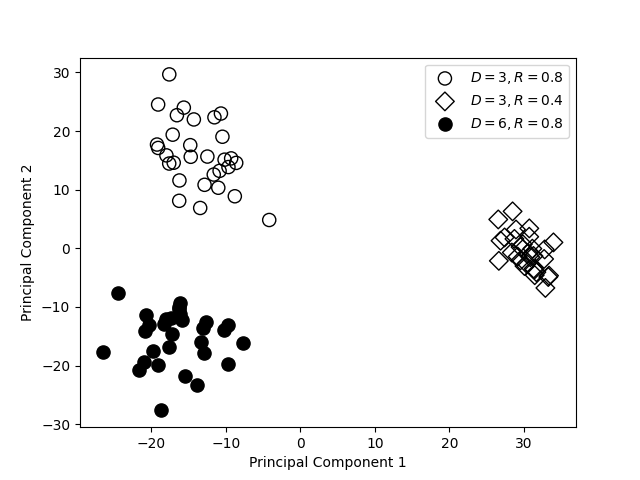

In [44]:
# Convert lists into an array
A = np.vstack([ec1,ec2,ec3])

# Perform PCA
pca = PCA()
X = pca.fit_transform(np.nan_to_num(zscore(A)))

# Plot the results
plt.figure()
plt.scatter(X[0:30,0],X[0:30,1],90,label = "$D=3,R=0.8$",facecolor = "None",edgecolor = 'k')

plt.scatter(X[30:60,0],X[30:60,1],90,marker = 'D', label = "$D=3,R=0.4$",facecolor = "None",edgecolor = 'k')

plt.scatter(X[60:90,0],X[60:90,1],90,'k', label = "$D=6,R=0.8$")

plt.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

As before, we will again compare the PCA of the ECs with the PCA of the Fourier transforms. The Fourier transform fails to capture the "shape" of these systems like the ECs did.

<IPython.core.display.Javascript object>


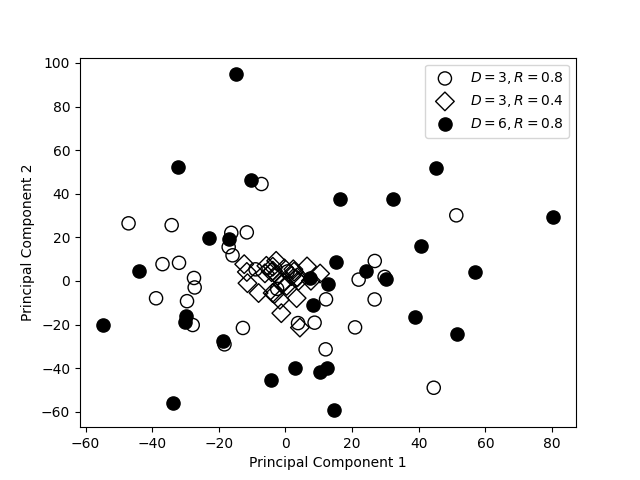

In [45]:
A = np.vstack([fft1,fft2,fft3])

pca = PCA()

X = pca.fit_transform(zscore(A))

plt.figure()
plt.scatter(X[0:30,0],X[0:30,1],90, label = "$D=3,R=0.8$",facecolor = "None",edgecolor = 'k')

plt.scatter(X[30:60,0],X[30:60,1],90, marker = 'D', label = "$D=3,R=0.4$",facecolor = "None",edgecolor = 'k')

plt.scatter(X[60::,0],X[60::,1],90,'k', label = "$D=6,R=0.8$")

plt.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()